# Computing ApRES profiles
Applying an fat fourier transform (fft) to raw ApRES data produces complex profile that is used to compting vertical displacement. 

The simplest way to compute the fft is when you load the ApRES data. By default, `xapres.load.load_all` and `xapres.generate_xarray` compute the fft and add the complex profiles to the xarray dataset (see {ref}`page:how-to-loading`).

In [1]:
import sys
sys.path.append("../../../xapres") 
import xapres as xa

## Perform the FFT when you load ApRES data

In [2]:
p = xa.load.generate_xarray(directory='../../data/sample/multi-burst-dat-file', bursts_to_process=[0])
p

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


<xarray.Dataset> Size: 39MB
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 20,
                      attenuator_setting_pair: 2, profile_range: 39999)
Coordinates:
  * time             (time) datetime64[ns] 8B 2022-05-22T19:40:20
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 160B 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
    filename         (time) <U62 248B '../../data/sample/multi-burst-dat-file...
    burst_number     (time) int64 8B 0
    AFGain           (attenuator_setting_pair) int64 16B -14 -14
    attenuator       (attenuator_setting_pair) float64 16B 10.0 20.0
    orientation      (time) <U7 28B 'unknown'
  * profile_range    (profile_range) float64 320kB 0.0 0.2103 ... 8.411e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 13MB ...
    latitude         (time) float64 8B 69.22
    longitude        (time) float64 8B -51.12
    battery_voltage  (time) float64 8B 12.33
    temperature_1    (time) float64 8B 4.383
    temperature_2    (time) float64 8B 5.195
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 26MB ...
Attributes:
    constants:   {'c': 300000000.0, 'K': 200000000.0, 'f_1': 200000000, 'f_2'...
    processing:  Created on 2025-01-07 17:28:59.908736

### Custom fft parameters when loading data
There are a number of options you can set when computing profiles. The most important ones are:
:`pad_factor`: The chirp is padded with zeros before the fft is performed to compute profiles. The defualt pad factor is 2. 
:`crop_chirp_start` and `crop_chirp_end`: The chirps are typically 1 second long and by default the whole chirp is used to compute the fft. To crop the chirp to only use part of it you can change these two settings. For example, to use the first half of each chirp, set `crop_chirp_start`=0 and `crop_chirp_end`=0.5.
:`max_range`, the depth to crop profiles to.
 
To change setting when calling `load_all` or `generate_xarray` you must pass a dictionary with the settings you want to change. For example, to change the pad factor to 4 and crop the chirps to only use the first half of each chirp, you would call `load_all` as follows:

In [3]:
settings = {'pad_factor': 4, 'crop_chirp_start': 0, 'crop_chirp_end': 0.5}

custom_fft_settings = xa.load.from_dats()

custom_fft_settings_data_1 = custom_fft_settings.load_all(directory='../../data/sample/single_dat_file/', 
            file_numbers_to_process = [0], 
            bursts_to_process=[0],
            addProfileToDs_kwargs = settings           
           )
custom_fft_settings_data_1

100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


<xarray.Dataset> Size: 145MB
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 69999)
Coordinates:
  * time             (time) datetime64[ns] 8B 2023-01-05T03:16:15
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U57 228B '../../data/sample/single_dat_file/DATA...
    burst_number     (time) int64 8B 0
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 22.0
    orientation      (time) <U7 28B 'unknown'
  * profile_range    (profile_range) float64 560kB 0.0 0.1202 ... 8.411e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 32MB ...
    latitude         (time) float64 8B 0.0
    longitude        (time) float64 8B 0.0
    battery_voltage  (time) float64 8B 0.0
    temperature_1    (time) float64 8B 2.891
    temperature_2    (time) float64 8B -0.172
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 112MB ...
Attributes:
    constants:   {'c': 300000000.0, 'K': 200000000.0, 'f_1': 200000000, 'f_2'...
    processing:  Created on 2025-01-07 17:29:00.286193

You can do the same with `generate_xarray`:

In [4]:
import numpy as np
custom_fft_settings_data_2 = xa.load.generate_xarray(directory='../../data/sample/single_dat_file/', 
            file_numbers_to_process = [0], 
            bursts_to_process=[0],
            addProfileToDs_kwargs = settings);
np.allclose(custom_fft_settings_data_2.profile, custom_fft_settings_data_1.profile)

100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


True

## Performing an fft on pre-loaded data
You can also compute the fft on data that has already been loaded. This is useful becuase you may want to try different settings on the fft without having to load the data from dats files each time. To do this you have a choice, either you use `computeProfile` on a dataarray containing the chirps, or you use `addProfileToDs` on a dataset output from `load_all`, `from_zarr`, or `generate_xarray`, which will replace the existing profiles if they exist with new ones in a the dataset it returns. 

The following demonstrates how to use `computeProfile` on a data array containing just chirps. It also shows how to set custom settings. In this case it sets the max_range and the crop start time.

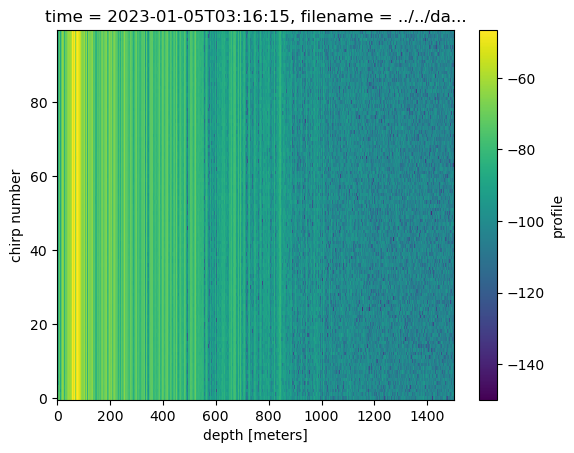

In [5]:
custom_fft_settings_data_2.chirp.computeProfile(max_range=1500, crop_chirp_start = 0.5).dB().plot();

To add profiles to (or replace existing profiles in) a dataset you use `addProfileToDs`: 

In [6]:
profiles_replaced = custom_fft_settings_data_2.addProfileToDs(crop_chirp_start = 0.5, pad_factor=2, max_range = 1500)
profiles_replaced

<xarray.Dataset> Size: 41MB
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 5350)
Coordinates:
  * time             (time) datetime64[ns] 8B 2023-01-05T03:16:15
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U57 228B '../../data/sample/single_dat_file/DATA...
    burst_number     (time) int64 8B 0
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 22.0
    orientation      (time) <U7 28B 'unknown'
  * profile_range    (profile_range) float64 43kB 0.0 0.2804 ... 1.5e+03 1.5e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 32MB ...
    latitude         (time) float64 8B 0.0
    longitude        (time) float64 8B 0.0
    battery_voltage  (time) float64 8B 0.0
    temperature_1    (time) float64 8B 2.891
    temperature_2    (time) float64 8B -0.172
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 9MB ...
Attributes:
    constants:   {'c': 300000000.0, 'K': 200000000.0, 'f_1': 200000000, 'f_2'...
    processing:  Created on 2025-01-07 17:29:01.828885

Notice how the shape of the length of the profiles have changed becuase the `max_range` and `crop_chirp_start` settings are different.

In [7]:
print(f"length of profiles computed with default settings: {len(custom_fft_settings_data_2.profile_range)}")
print(f"length of profiles computed with changed settings: {len(profiles_replaced.profile_range)}")

length of profiles computed with default settings: 69999
length of profiles computed with changed settings: 5350


### Constants
You can also change the values of constants used in the fft computatiion. When you load the data from dat files with `load_all` the function looks for the values of these constants in the dat file headers and saves them in the attributes of the returned dataset. It uses these values when computing the fft.

`addProfileToDs` also uses these constants for the fft computation (in fact `load_all` calls `addProfileToDs` to compute the profiles). 

To change the value of these setting used in the fft you can pass a dictionary including the new constants as follows: 

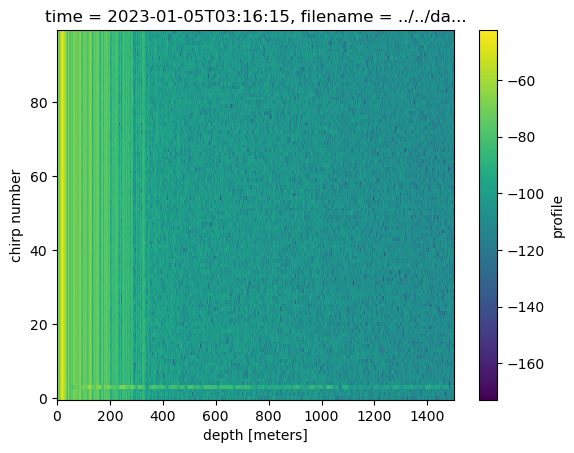

In [8]:
constants = {'c': 1e8}
differentConstants = custom_fft_settings_data_2.chirp.computeProfile(constants=constants, max_range = 1500)
differentConstants.dB().plot();

Notice how the plot is the same as the plot above, except that the reflectors are shifted towards the left (smaller depths) because we are using a lower velocity for the radio waves. 

## Summary
To compute profiles we apply an fft to raw ApRES data. 
This happens by default when you load data with `xapres.load.load_all` or `xapres.generate_xarray`.
You can also compute profiles on pre-loaded data using `computeProfile` or `addProfileToDs`.
`computeProfile` is a method of xarray dataarrays and can be applied to the dataa array containing the chirps.
`addProfileToDs` is a method of xarray datasets and can be applied to dataset produced by `xapres.load.load_all` or `xapres.generate_xarray`.
In all case you can change settings used in the computation. For `xapres.load.load_all` or `xapres.generate_xarray` you pass a dictionary of settings for  `computeProfile` or `addProfileToDs` you pass the options as individual keyword arguments. 
See {ref}`page:api-reference` for full list of the options you can set.